In [1]:
from scipy import fft
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
# from tf.keras.dataset import mnist
from matplotlib.pyplot import figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image, ImageOps
import requests
import random

(train_X, train_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()
np.set_printoptions(threshold=100)

In [2]:
def draw_mnist(data, axs=None):
    if axs == None:
        plt.imshow(data.reshape(28, 28), cmap=plt.get_cmap('gray'))
        plt.axis('off')
        plt.show()
    else:
        axs.imshow(data.reshape(28, 28), cmap=plt.get_cmap('gray'))
        axs.axis('off')
        
def hamming_error(V1, V2):
    total = 0
    for i in range(len(V1)):
        total += np.abs(V1[i] - V2[i])
        
    return total

In [3]:
class HDEncoder:
    def __init__(self, n, D=10000):
        self.n = n
        self.D = D
        self.B = [ 2 * np.random.randint(2, size=self.D) - 1 for i in range(self.n)]
        self.H = np.zeros(self.D)
        self.original = []
        
    def encode(self, features):
        self.original = features
        
        for i, f in enumerate(features):
            self.H = self.H + f * self.B[i]
            
    def drop_random(self, R):
        indices = random.sample(range(1, self.D), R)
        
        for i in indices:
            self.H[i] = 0
            
    def decode(self, iterations, verbose=False):
        F = []
        
        features = np.zeros(self.n)
        
        for i in range(self.n):
            features[i] = np.round((self.H @ self.B[i]) / self.D)
            
        F.append(features)
        
        if iterations != 1:
            Fprev = features
            Hprev = self.H
            
            for i in range(1, iterations):
                Fi = np.zeros(self.n)
                Hi = np.zeros(self.D)
                dH = np.zeros(self.D)
                Ei = np.zeros(self.n)
                
                for j, f in enumerate(Fprev):
                    Hi = Hi + f * self.B[j]
                dH = self.H - Hi
                
                for j in range(self.n):
                    Ei[j] = np.round((dH @ self.B[j]) / self.D)
                    
                Fi = Fprev + Ei
                F.append(Fi)
                
                Hprev = Hi
                Fprev = Fi
        return F
                

## Experiments

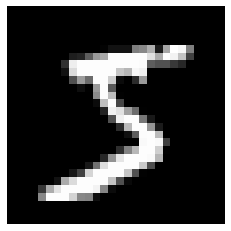

In [4]:
data1 = train_X[0]
draw_mnist(data1)

### Encoding detail

In [74]:
features = 784
dim = 10000
B = [ 2 * np.random.randint(2, size=dim) - 1 for i in range(features)]
H = np.zeros(dim)

In [75]:
np.array(B).shape

(784, 10000)

In [76]:
original = data1.reshape(1, 784)[0]

for i, f in enumerate(original):
    H = H + f * B[i]

In [77]:
np.array(B).shape

(784, 10000)

In [81]:
import torch
B_custom = torch.randn(dim, features)
B_custom, B_custom.shape

(tensor([[-1.0724, -0.2443,  1.1472,  ...,  0.0776,  2.6735, -0.6293],
         [-0.8937, -0.5086,  1.1250,  ...,  1.1045,  1.0109,  1.6756],
         [-1.1483, -1.5929, -1.0564,  ..., -1.2918,  0.9405,  1.2298],
         ...,
         [ 1.2476,  0.4679,  0.3687,  ..., -0.0428, -0.0730, -0.2132],
         [-0.0645,  2.2531, -1.7397,  ...,  0.2052,  0.6711,  0.1188],
         [-0.7848,  0.2394, -0.5753,  ...,  0.6482,  0.6026,  1.3961]]),
 torch.Size([10000, 784]))

In [82]:
h = torch.empty(1, 10000)
h.shape

torch.Size([1, 10000])

### Decoding detail

In [92]:
B_custom[0].shape

torch.Size([784])

In [93]:
n = 784
F = []

features = np.zeros(n)

for i in range(n):
    features[i] = np.round((H @ B[i]) / D)

F.append(features)

In [88]:
features.shape

torch.Size([784])

In [61]:
(H @ B[i])

-191412.0

In [66]:
iterations = 20

if iterations != 1:
    Fprev = features
    Hprev = H

    for i in range(1, iterations):
        Fi = np.zeros(n) # 784
        Hi = np.zeros(D) # 10000
        dH = np.zeros(D) # 10000
        Ei = np.zeros(n) # 784

        print("iterations : ", i)
        print("Fi : ", Fi, "\nHi : ", Hi, "\ndH : ", dH, "\nEi : ", Ei, "\n===")
        
        for j, f in enumerate(Fprev):
            Hi = Hi + f * B[j]
        dH = H - Hi

        print("Fi : ", Fi, "\nHi : ", Hi, "\ndH : ", dH, "\nEi : ", Ei, "\n===")
        
        for j in range(n):
            Ei[j] = np.round((dH @ B[j]) / D)

        print("Fi : ", Fi, "\nHi : ", Hi, "\ndH : ", dH, "\nEi : ", Ei, "\n===")    
        
        Fi = Fprev + Ei
        F.append(Fi)

        print("Fi : ", Fi, "\nHi : ", Hi, "\ndH : ", dH, "\nEi : ", Ei, "\n===")
        
        Hprev = Hi
        Fprev = Fi

iterations :  1
Fi :  [0. 0. 0. ... 0. 0. 0.] 
Hi :  [0. 0. 0. ... 0. 0. 0.] 
dH :  [0. 0. 0. ... 0. 0. 0.] 
Ei :  [0. 0. 0. ... 0. 0. 0.] 
===
Fi :  [0. 0. 0. ... 0. 0. 0.] 
Hi :  [  806. -3688. -1102. ... -1694. -2142.   812.] 
dH :  [ 811.  253.  467. ...  927. -349. -355.] 
Ei :  [0. 0. 0. ... 0. 0. 0.] 
===
Fi :  [0. 0. 0. ... 0. 0. 0.] 
Hi :  [  806. -3688. -1102. ... -1694. -2142.   812.] 
dH :  [ 811.  253.  467. ...  927. -349. -355.] 
Ei :  [16. 12.  7. ... -7. 41. -3.] 
===
Fi :  [ 1. -7.  5. ... -8.  0.  6.] 
Hi :  [  806. -3688. -1102. ... -1694. -2142.   812.] 
dH :  [ 811.  253.  467. ...  927. -349. -355.] 
Ei :  [16. 12.  7. ... -7. 41. -3.] 
===
iterations :  2
Fi :  [0. 0. 0. ... 0. 0. 0.] 
Hi :  [0. 0. 0. ... 0. 0. 0.] 
dH :  [0. 0. 0. ... 0. 0. 0.] 
Ei :  [0. 0. 0. ... 0. 0. 0.] 
===
Fi :  [0. 0. 0. ... 0. 0. 0.] 
Hi :  [ 1507. -3139.  -573. ...  -619. -2221.   785.] 
dH :  [ 110. -296.  -62. ... -148. -270. -328.] 
Ei :  [0. 0. 0. ... 0. 0. 0.] 
===
Fi :  [0. 0. 0

In [ ]:
F

### Encoding step

In [37]:
en_1000 = HDEncoder(28 * 28, D=1000)
en_1000.encode(data1.reshape(1, 784)[0])

en_4000 = HDEncoder(28 * 28, D=4000)
en_4000.encode(data1.reshape(1, 784)[0])

en_7000 = HDEncoder(28 * 28, D=7000)
en_7000.encode(data1.reshape(1, 784)[0])

en_10000 = HDEncoder(28 * 28, D=10000)
en_10000.encode(data1.reshape(1, 784)[0])

print("D = 1000:", en_1000.H, ", \n shape:", en_1000.H.shape, "\n")
print("D = 4000:", en_4000.H, ", \n shape:", en_4000.H.shape, "\n")
print("D = 7000:", en_7000.H, ", \n shape:", en_7000.H.shape, "\n")
print("D = 10000:", en_10000.H, ", \n shape:", en_10000.H.shape, "\n")

D = 1000: [ 3885.  -227.  3213. ...  1989.  1009. -2811.] , 
 shape: (1000,) 

D = 4000: [-3205. -1117.   303. ...  3617.  -731.  3015.] , 
 shape: (4000,) 

D = 7000: [ 3817.  2657.  -881. ...  -231. -1505.   327.] , 
 shape: (7000,) 

D = 10000: [-1025.  1403. -1547. ...  2567. -5011. -1403.] , 
 shape: (10000,) 



## Decoding step

(784,)

In [38]:
iterations = 10
F = {}

F[1000] = en_1000.decode(iterations)
F[4000] = en_4000.decode(iterations)
F[7000] = en_7000.decode(iterations)
F[10000] = en_10000.decode(iterations)

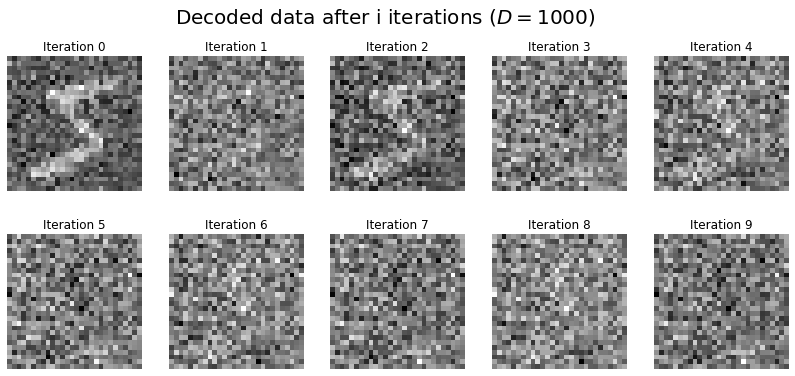

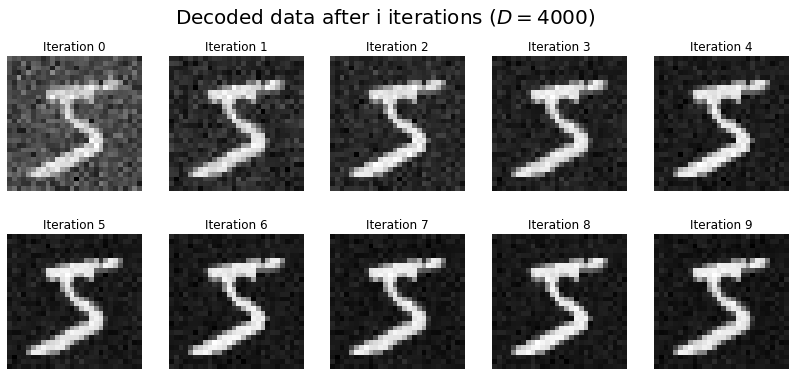

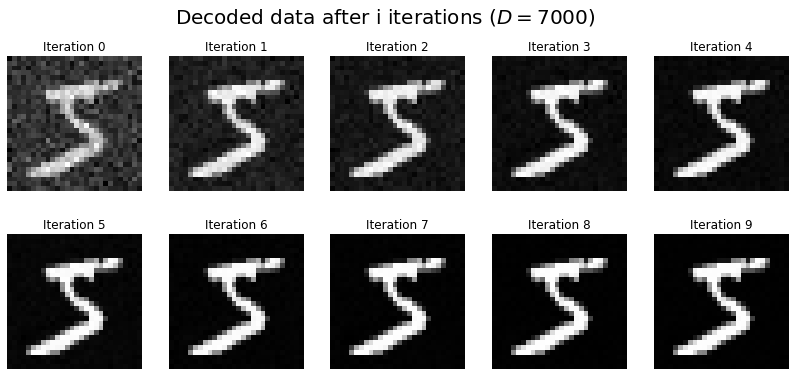

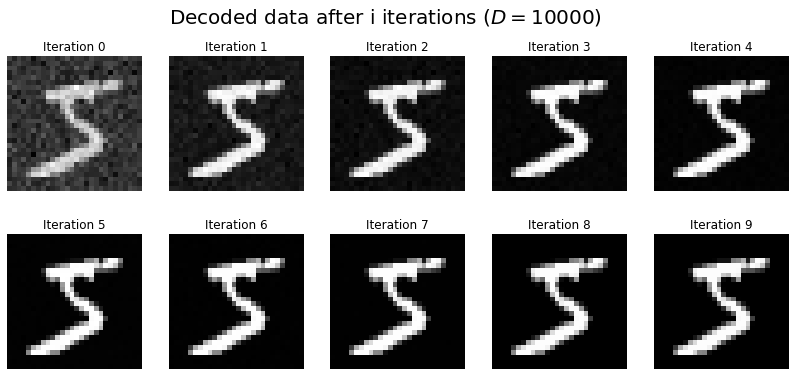

In [33]:
fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
    idx = i // 5
    idy = i % 5
    draw_mnist(F[1000][i], axs=axs[idx, idy])
    axs[idx, idy].set_title(f'Iteration {i}')
    
fig.suptitle("Decoded data after i iterations ($D=1000$)", fontsize=20)
plt.show()

print()
print()

fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
    idx = i // 5
    idy = i % 5
    draw_mnist(F[4000][i], axs=axs[idx, idy])
    axs[idx, idy].set_title(f'Iteration {i}')
    
fig.suptitle("Decoded data after i iterations ($D=4000$)", fontsize=20)
plt.show()

print()
print()

fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
    idx = i // 5
    idy = i % 5
    draw_mnist(F[7000][i], axs=axs[idx, idy])
    axs[idx, idy].set_title(f'Iteration {i}')
    
fig.suptitle("Decoded data after i iterations ($D=7000$)", fontsize=20)
plt.show()

print()
print()

fig, axs = plt.subplots(2, 5, figsize=(14, 6))

for i in range(iterations):
    idx = i // 5
    idy = i % 5
    draw_mnist(F[10000][i], axs=axs[idx, idy])
    axs[idx, idy].set_title(f'Iteration {i}')
    
fig.suptitle("Decoded data after i iterations ($D=10000$)", fontsize=20)
plt.show()

print()
print()

## To compare the performance by values of D, examine the following plot of each iteration and its decoding accuracy

In [34]:
var = {}
error = {}

for d in [1000, 4000, 7000, 10000]:
    var[d] = []
    error[d] = []
    for i in range(iterations):
        var[d].append(np.var(F[d][i]))
        e = hamming_error(F[d][i], data1.reshape(784))
        error[d].append(e)

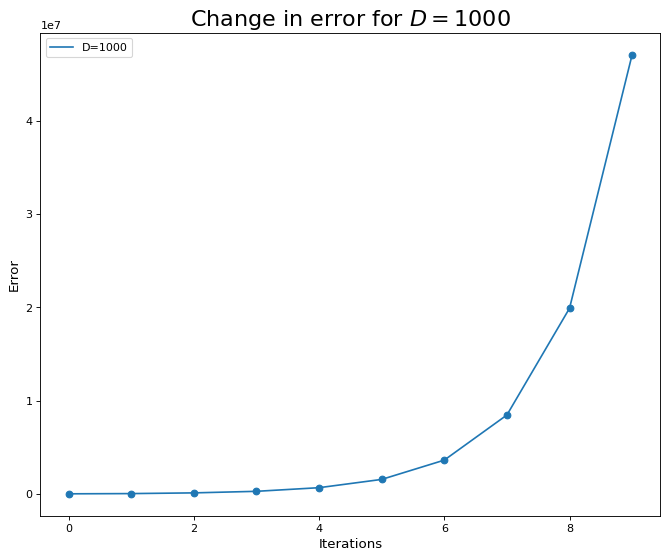

In [35]:
figure(figsize=(10, 8), dpi=80)

plt.plot(range(iterations), error[1000])
plt.scatter(range(iterations), error[1000])

plt.legend(labels=["D=1000"])
plt.title("Change in error for $D=1000$", fontsize=20)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Error", fontsize=12)

plt.show()

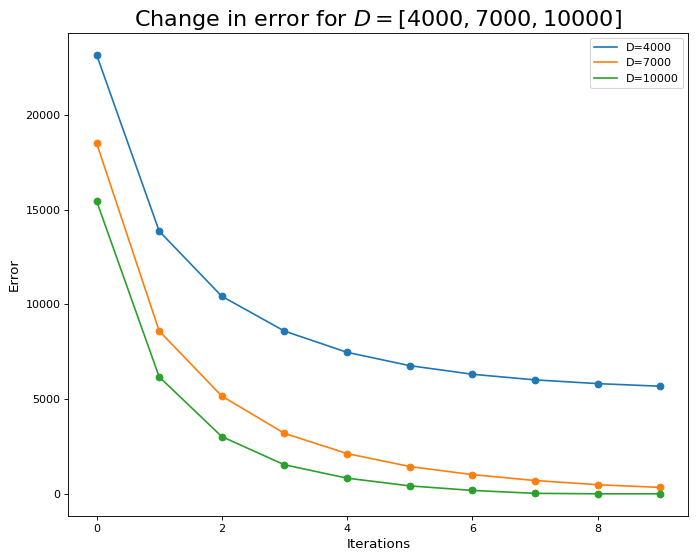

In [36]:
figure(figsize=(10, 8), dpi=80)

plt.plot(range(iterations), error[4000])
plt.scatter(range(iterations), error[4000])
plt.plot(range(iterations), error[7000])
plt.scatter(range(iterations), error[7000])
plt.plot(range(iterations), error[10000])
plt.scatter(range(iterations), error[10000])

plt.legend(labels=["D=4000", "D=7000", "D=10000"])

plt.title("Change in error for $D = [4000, 7000, 10000]$", fontsize=20)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Error", fontsize=12)

plt.show()

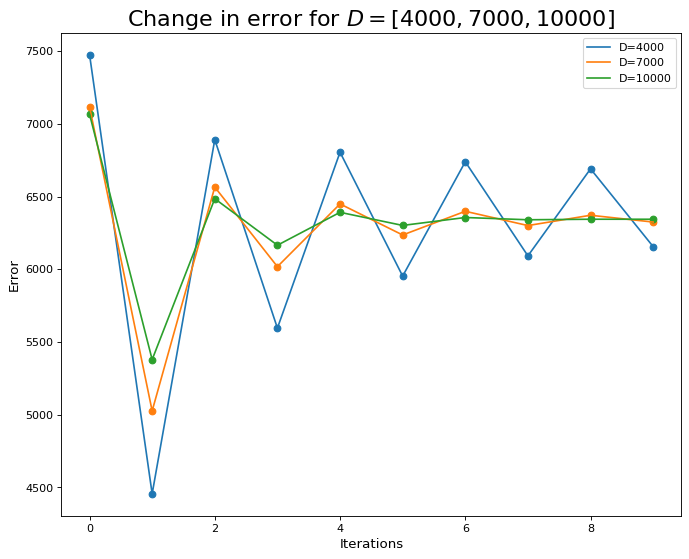

In [38]:
figure(figsize=(10, 8), dpi=80)

# plt.plot(range(iterations), var[1000])
# plt.scatter(range(iterations), var[1000])
plt.plot(range(iterations), var[4000])
plt.scatter(range(iterations), var[4000])
plt.plot(range(iterations), var[7000])
plt.scatter(range(iterations), var[7000])
plt.plot(range(iterations), var[10000])
plt.scatter(range(iterations), var[10000])

plt.legend(labels=["D=4000", "D=7000", "D=10000"])

plt.title("Change in error for $D = [4000, 7000, 10000]$", fontsize=20)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Error", fontsize=12)

plt.show()